# HMM defect detection

In [1]:
# Detailed steps:
# The code is based on the essay 'Archive Film Defect Detection and Removal: An Automatic Restoration Framework'
# 1. extract video into frames
# 2. choose 13 consecutive frames and extract the intensity value at the same pixel location as an observation sequence(length=13)
# 3. union the sequence to form a Height = 4, Width = 1920*1080, 2D numpy array as the training data set
# 4. classify the intensity value 0-255 into 0-6, 7 obervation class in total(as proposed in the essay)
# 5. Define an HMM model with 5 states(as proposed in the essay)
# 6. Train the HMM model with the training data set acquired in 3
# 7. Choose a random test sequence. Leave one of the 13 values out and compute the 'likihood of the observation sequence' V(k) each time
# 8. Calculate the average of V(k). If the V(k) of central pixel, that is V(7), is higher than average, we believe that V(7) is degraded.

# Observation
# In my simplify version(4 observation class), I input an 0, 0, 3, 0, 0. 
# The leave one out process return a much higher probability when 3 is removed. 
# I believe that unity pattern return higher probability.

# Problem
# 1. What is the likelihood of the observation sequence, is it the score return by hmm.score(sequence)?
# 2. In the essay, it contains a graphing illustration of transition of states(e.g. BG->intermediate->FG->intermediate->BG)
# Should I specify it in my hmm model? Or it just a guessing of author that how hmm works when states = 5 ?

# Difficulties and further work
# 1. The essay said 'The training data was extracted at random positions from 10 different types of archive film
# (5 grayscale and 5 color image sequences.) In total, 207561 observation sequences were used for training the hmm theta'
# I use 1920*1080 full picture for 13 frame and there is 2,073,600‬, and my computer complete stucked with CPU occupation 99%

# Solution
# 1. Set up GPU for anaconda
# 2. Reduce training set size by random selection

## 1.Import libs (Run)

In [5]:
from __future__ import print_function
import numpy as np
from hmmlearn import hmm
import cv2
import os
import sys
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from scipy import signal
import random
import math
import torch
import torch.nn.functional as F
import pandas as pd
%matplotlib inline
from HiddenMarkovModel import HiddenMarkovModel
# https://gist.github.com/jackdoerner/1c9c48956a1e00a29dbc
import struct
import datetime
import time

## 2.Utilities (Run)

In [6]:
orientations = {
	0: "Left to Right, Top to Bottom",
	1: "Right to Left, Top to Bottom",
	2: "Left to Right, Bottom to Top",
	3: "Right to Left, Bottom to Top",
	4: "Top to Bottom, Left to Right",
	5: "Top to Bottom, Right to Left",
	6: "Bottom to Top, Left to Right",
	7: "Bottom to Top, Right to Left"
}

descriptors = {
	1: "Red",
	2: "Green",
	3: "Blue",
	4: "Alpha",
	6: "Luma (Y)",
	7: "Color Difference",
	8: "Depth (Z)",
	9: "Composite Video",
	50: "RGB",
	51: "RGBA",
	52: "ABGR",
	100: "Cb, Y, Cr, Y (4:2:2)",
	102: "Cb, Y, Cr (4:4:4)",
	103: "Cb, Y, Cr, A (4:4:4:4)"
}

packings = {
	0: "Packed into 32-bit words",
	1: "Filled to 32-bit words, Padding First",
	2: "Filled to 32-bit words, Padding Last"
}

encodings = {
	0: "No encoding",
	1: "Run Length Encoding"
}

transfers = {
	1: "Printing Density",
	2: "Linear",
	3: "Logarithmic",
	4: "Unspecified Video",
	5: "SMPTE 274M",
	6: "ITU-R 709-4",
	7: "ITU-R 601-5 system B or G",
	8: "ITU-R 601-5 system M",
	9: "Composite Video (NTSC)",
	10: "Composite Video (PAL)",
	11: "Z (Linear Depth)",
	12: "Z (Homogenous Depth)"
}

colorimetries = {
	1: "Printing Density",
	4: "Unspecified Video",
	5: "SMPTE 274M",
	6: "ITU-R 709-4",
	7: "ITU-R 601-5 system B or G",
	8: "ITU-R 601-5 system M",
	9: "Composite Video (NTSC)",
	10: "Composite Video (PAL)"
}

propertymap = [
	#(field name, offset, length, type)

	('magic', 0, 4, 'magic'),
	('offset', 4, 4, 'I'),
	('dpx_version', 8, 8, 'utf8'),
	('file_size', 16, 4, 'I'),
	('ditto', 20, 4, 'I'),
	('filename', 36, 100, 'utf8'),
	('timestamp', 136, 24, 'utf8'),
	('creator', 160, 100, 'utf8'),
	('project_name', 260, 200, 'utf8'),
	('copyright', 460, 200, 'utf8'),
	('encryption_key', 660, 4, 'I'),

	('orientation', 768, 2, 'H'),
	('image_element_count', 770, 2, 'H'),
	('width', 772, 4, 'I'),
	('height', 776, 4, 'I'),

	('data_sign', 780, 4, 'I'),
	('descriptor', 800, 1, 'B'),
	('transfer_characteristic', 801, 1, 'B'),
	('colorimetry', 802, 1, 'B'),
	('depth', 803, 1, 'B'),
	('packing', 804, 2, 'H'),
	('encoding', 806, 2, 'H'),
	('line_padding', 812, 4, 'I'),
	('image_padding', 816, 4, 'I'),
	('image_element_description', 820, 32, 'utf8'),

	('input_device_name', 1556, 32, 'utf8'),
	('input_device_sn', 1588, 32, 'utf8')
]

def readDPXMetaData(f):
	f.seek(0)
	bytes = f.read(4)
	magic = bytes.decode(encoding='UTF-8')
	if magic != "SDPX" and magic != "XPDS":
		return None
	endianness = ">" if magic == "SDPX" else "<"

	meta = {}

	for p in propertymap:
		f.seek(p[1])
		bytes = f.read(p[2])
		if p[3] == 'magic':
			meta[p[0]] = bytes.decode(encoding='UTF-8')
			meta['endianness'] = "be" if magic == "SDPX" else "le"
		elif p[3] == 'utf8':
			meta[p[0]] = bytes.decode(encoding='UTF-8')
		elif p[3] == 'B':
			meta[p[0]] = struct.unpack(endianness + 'B', bytes)[0]
		elif p[3] == 'H':
			meta[p[0]] = struct.unpack(endianness + 'H', bytes)[0]
		elif p[3] == 'I':
			meta[p[0]] = struct.unpack(endianness + 'I', bytes)[0]

	return meta

def readDPXImageData(f, meta):
    if meta['depth'] != 10 or meta['packing'] != 1 or meta['encoding'] != 0 or meta['descriptor'] != 50:
        return None

    width = meta['width']
    height = meta['height']
    image = np.empty((height, width, 3), dtype=float)# Not float, but int

    f.seek(meta['offset'])
    raw = np.fromfile(f, dtype=np.dtype(np.int32), count=width*height, sep="")
    raw = raw.reshape((height,width))

    if meta['endianness'] == 'be':
        raw = raw.byteswap()

    image[:,:,0] = (((raw >> 22) & 0x000003FF)/ 0x000003FF)
    image[:,:,1] = (((raw >> 12) & 0x000003FF)/ 0x000003FF)
    image[:,:,2] = (((raw >> 2) & 0x000003FF)/ 0x000003FF)

    return image

def my_show_gray(img):
    plt.figure(figsize=(50,50))
    plt.imshow(img,cmap='gray')

def one_to_255(value):
    if (value==1):
        return 76
    else:
        return 0    

def extract_original(current_frame,index = 0, start_hor = 0, end_hor = 2100, start_ver = 0, end_ver = 1300):
    path_to_save = 'D:\珩珩工作室\polyu study\EIE4433\dataset\GreenStain_Dirts_Flicker_Original'
    name = 'Original.00' + str(current_frame) + '.dpx'
    f = open(os.path.join(path_to_save, name), "rb")
    meta = readDPXMetaData(f)
    img = readDPXImageData(f, meta)
    dst=img_as_ubyte(img)
    img_gray = cv2.cvtColor(dst,cv2.COLOR_RGB2GRAY)[start_ver:end_ver,start_hor:end_hor]
    img_color = dst[start_ver:end_ver,start_hor:end_hor,0:3]
    img_color = np.flip(img_color,2)
    return img_color.astype(np.int32),img_gray.astype(np.int32)

def extract_final(current_frame,index = 0, start_hor = 0, end_hor = 2100, start_ver = 0, end_ver = 1300):
    path_to_save = 'D:\珩珩工作室\polyu study\EIE4433\dataset\GreenStain_Dirts_Flicker_Final'
    name = 'Final.00' + str(current_frame) + '.dpx'
    f = open(os.path.join(path_to_save, name), "rb")
    meta = readDPXMetaData(f)
    img = readDPXImageData(f, meta)
    dst=img_as_ubyte(img)
    img_gray = cv2.cvtColor(dst,cv2.COLOR_RGB2GRAY)[start_ver:end_ver,start_hor:end_hor]
    img_color = dst[start_ver:end_ver,start_hor:end_hor,0:3]
    img_color = np.flip(img_color,2)
    return img_color.astype(np.int32),img_gray.astype(np.int32)


### Check function: extract_original; Remember to change the path of original and final frames

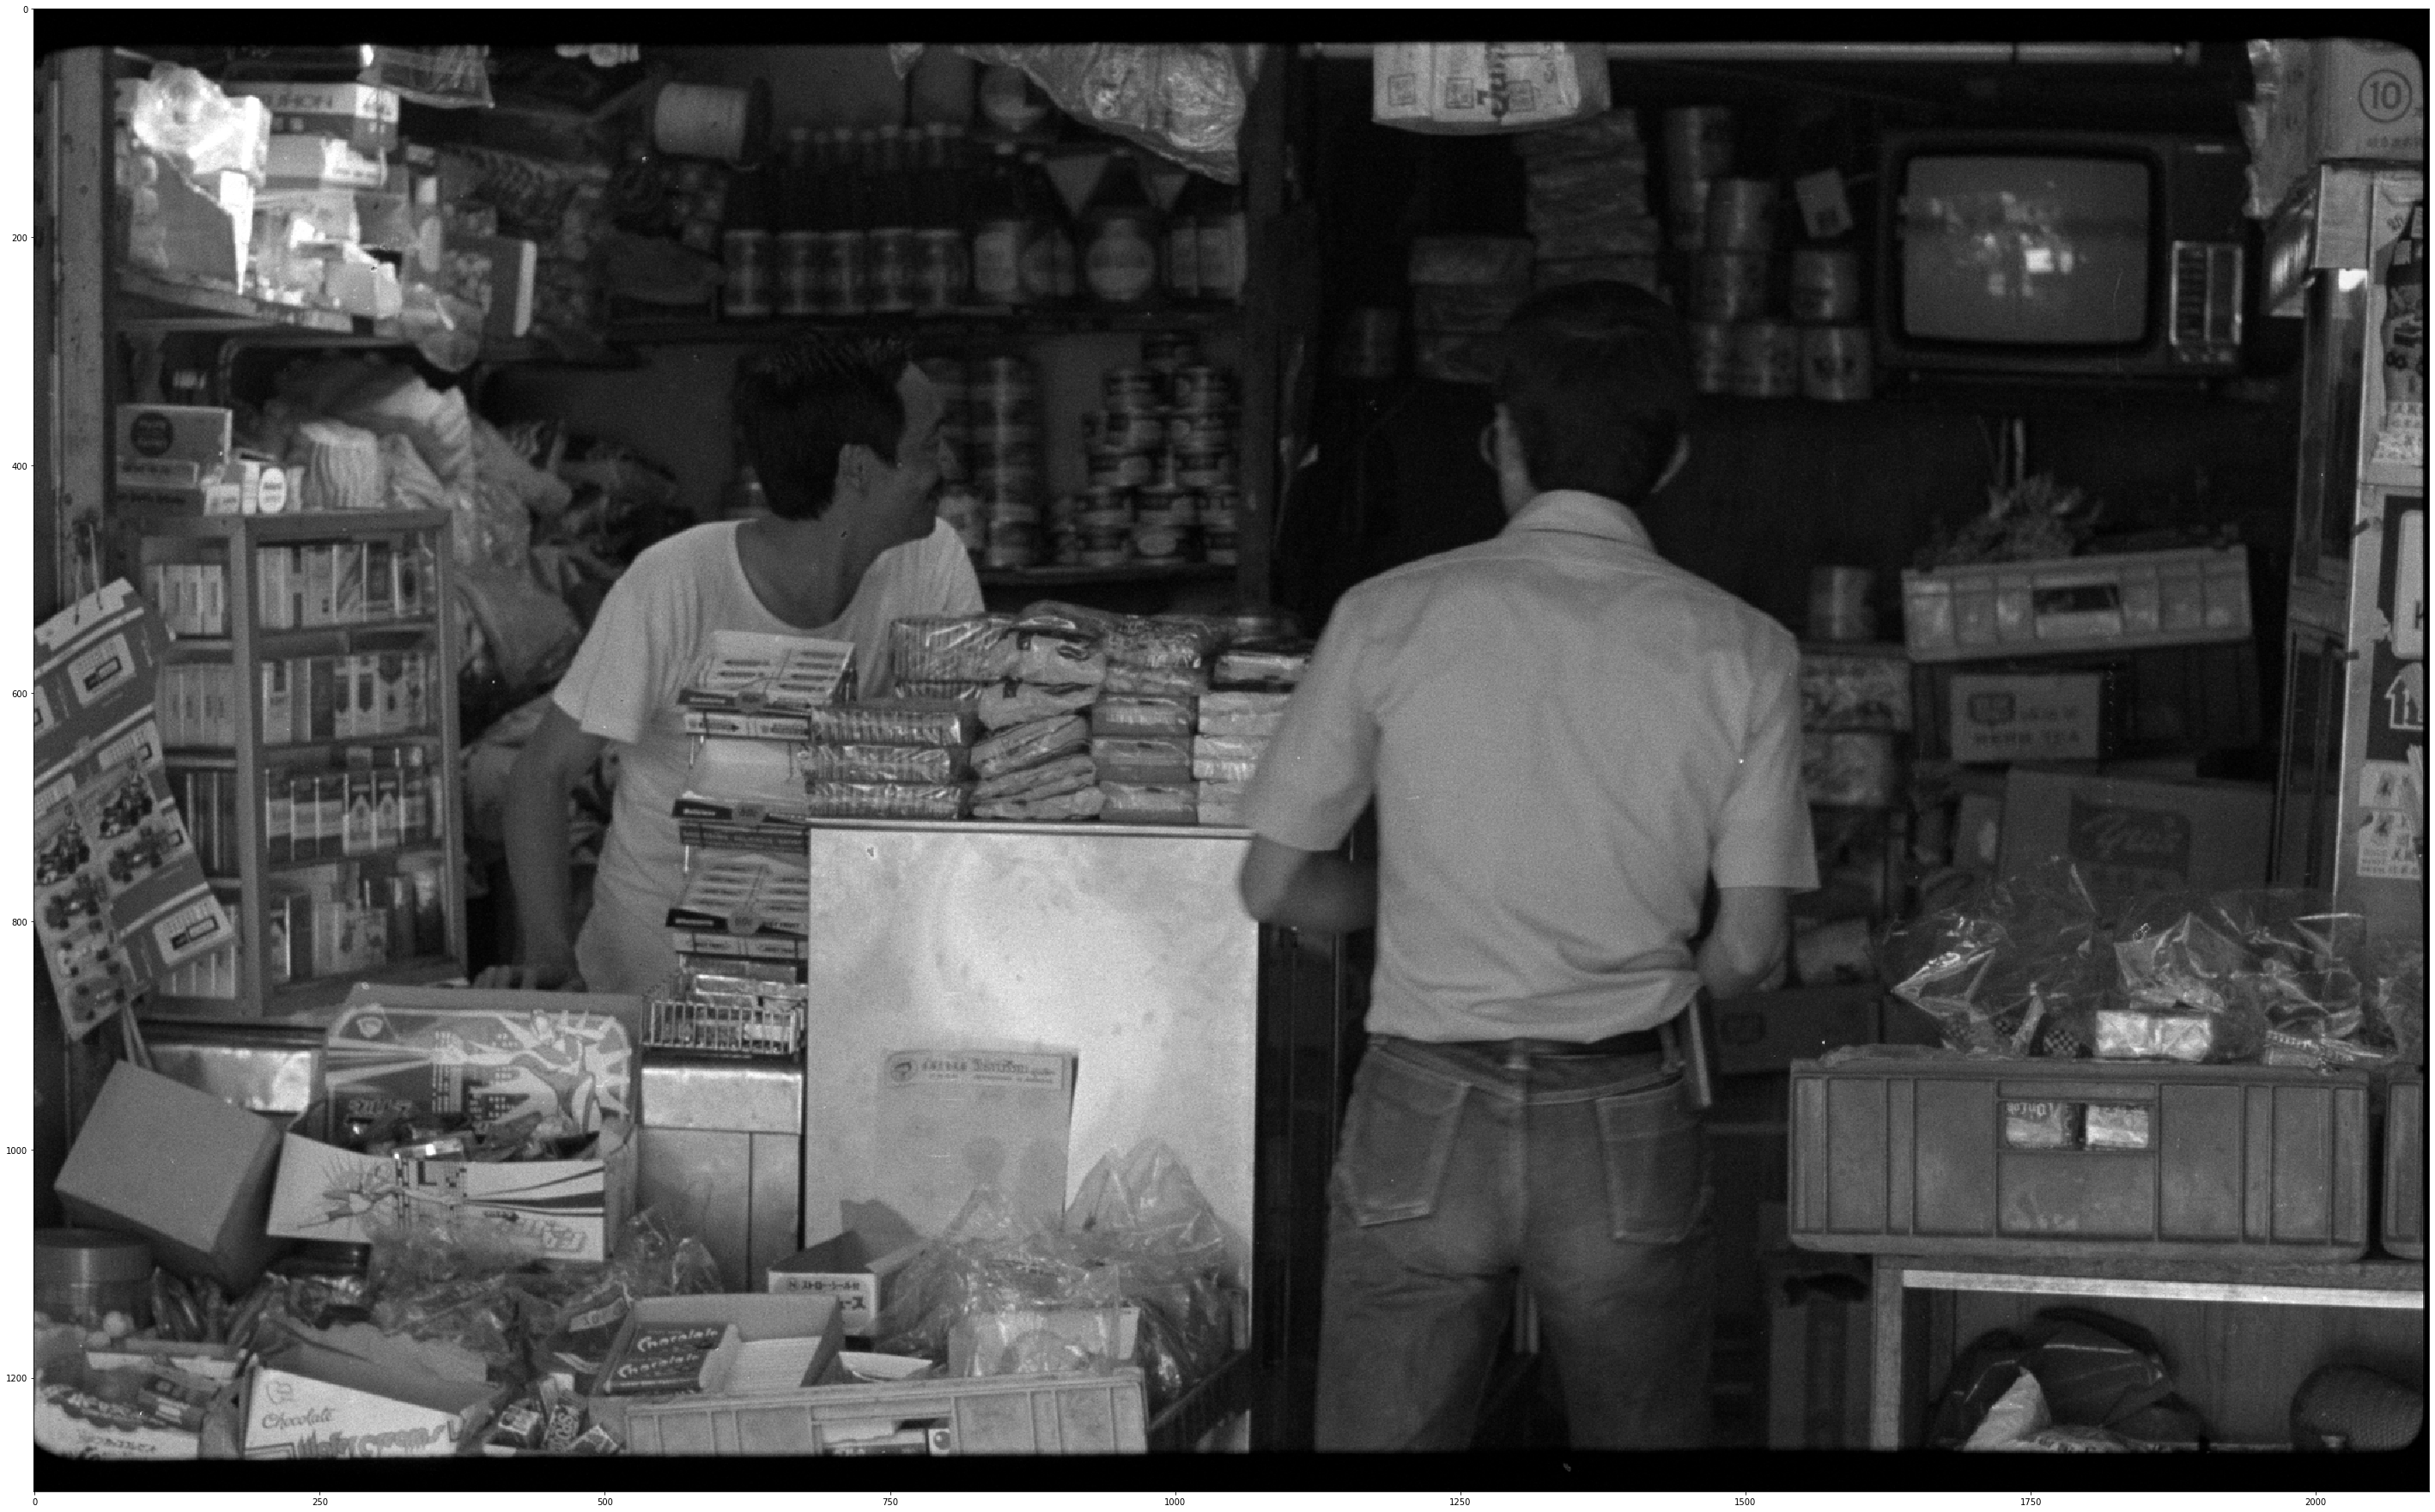

In [7]:
img_color,img_gray = extract_original(952239)
my_show_gray(img_gray)

## 3.Read Target Training Set (Run)

In [9]:
def read_training_set(current_frame):
    plt.figure(figsize=(50,50))
    #path_to_save = 'D:\珩珩工作室\polyu study\EIE4433\dataset\GreenStain_Dirts_Flicker_Original'
    path_to_save = 'D:\珩珩工作室\polyu study\EIE4433\dataset\GreenStain_Dirts_Flicker_Final'
    # 2909 frames in total, set stride = 200
    data = np.zeros((13,1300,2100))
    for i in range(0,13):
        img_color,img_gray = extract_final(i+current_frame-6)
        data[i]=img_gray
    return data

### Check function read_training_set; Package 13 frames together

In [10]:
data = read_training_set(952217)

<Figure size 3600x3600 with 0 Axes>

## 4.Randomly Extract Sample for HMM Training (Run)

In [12]:
# Full size
# h = 1080
# w = 1920
def extract_random_sample(num_of_hor, num_of_ver):
    h = num_of_ver
    w = num_of_hor
    H = random.sample(range(0,1300), h)
    W = random.sample(range(0,2100), w)

    observation = np.zeros((13,w*h))
    #print(observation)
    dataT=data.T
    # Full size will be too large
    for i in range(0,h):
        for j in range(0,w):
            ii = H[i]
            jj = W[j]
            observation[:,w*i+j] = dataT[jj][ii]
            #if (dataT[jj][ii][0] != 0):
                #print(dataT[jj][ii])
    # Check the observation sequence of 'observation'
    '''
    for i in range(0,1080):
        for j in range(0,1920):
            if (observation[0,1920*i+j] != 0):
                print('i+j=',1920*i+j,'ob=',observation[:,1920*i+j])
    '''
    #print(observation.shape)
    return observation

### Check function: extract_random_sample; Randomly extract 10000 artifacts-free sequence

In [13]:
observation = extract_random_sample(100, 100)
print(observation.shape)

(13, 10000)


## 5.Classify the sequence intensity value into 7 observations (Run)

In [14]:
def quantify_to_seven_2d(observation):
    observationC=np.zeros((observation.shape[0], observation.shape[1]))
    observationC[observation<36]=int(0)
    observationC[(observation>=36)&(observation<73)]=int(1)
    observationC[(observation>=73)&(observation<109)]=int(2)
    observationC[(observation>=109)&(observation<146)]=int(3)
    observationC[(observation>=146)&(observation<182)]=int(4)
    observationC[(observation>=182)&(observation<219)]=int(5)
    observationC[(observation>=219)&(observation<256)]=int(6)
    observationC=observationC.astype(int)
    return observationC

### Check function: quantify_to_seven_2d

In [15]:
observationC = quantify_to_seven_2d(observation)
print(observationC.shape)

(13, 10000)


## 6.Train hmm model - With autosaving the parameters with data&time (Run)

In [11]:
def train_hmm_model(observationC, save_index):
    # hidden state
    states = ["state 1", "state 2", "state 3", "state 4", "state 5"]
    n_states = len(states)

    # observed
    observations = ["O1", "O2", "O3", "O4", "O5", "O6", "O7"]
    n_observations = len(observations)

    # Time count
    import time
    start_time = time.time()

    #Train
    model2 = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01)

    # Training data set, observed
    model2.fit(observationC)

    print ('startprob_ = ',model2.startprob_)
    print ('transmat_ = ',model2.transmat_)
    print ('emissionprob = ',model2.emissionprob_)
    print ('score = ',model2.score(observationC))

    save_path = "D:/dataset/workspace/hmm/"
    np.savetxt(save_path + save_index + "startprob.txt", model2.startprob_ ,fmt='%f',delimiter=',')
    np.savetxt(save_path + save_index + "transmat.txt", model2.transmat_ ,fmt='%f',delimiter=',')
    np.savetxt(save_path + save_index + "emissionprob.txt", model2.emissionprob_ ,fmt='%f',delimiter=',')
    np.savetxt(save_path + save_index + "score.txt", (model2.score(observationC)).reshape(1,1) ,fmt='%f',delimiter=',')

    #dets= np.loadtxt('dets.txt',delimiter=',')

    # Time end
    print("--- %s seconds ---" % (time.time() - start_time))
    # 82 seconds for just 10000 sample and 100 iteration limit

### Check function train_hmm_model; Run this function will generate a model parameter set that can be reused if the performance is good

In [12]:
train_hmm_model(observationC, '0')

startprob_ =  [1.21858089e-018 6.26524607e-007 9.99999373e-001 8.54934293e-015
 1.48690371e-138]
transmat_ =  [[5.08282034e-01 4.22815308e-02 1.73125923e-01 2.76304467e-01
  6.04511145e-06]
 [1.72536566e-02 9.66744916e-01 1.23903111e-03 1.47623967e-02
  5.64983242e-12]
 [1.60806399e-01 6.64464363e-03 6.20703265e-01 1.93506567e-01
  1.83391255e-02]
 [3.11318437e-01 2.25386509e-02 3.00658128e-01 3.65123091e-01
  3.61693289e-04]
 [8.50934945e-06 1.70934313e-03 8.27798197e-03 2.29925924e-04
  9.89774240e-01]]
emissionprob =  [[1.72924095e-01 1.48417258e-01 1.94168166e-01 4.32290553e-01
  5.13417489e-02 8.58178995e-04 1.93380359e-17]
 [1.59995667e-01 2.10515459e-01 1.76776802e-01 1.60347250e-01
  1.76392222e-01 1.08735653e-01 7.23694845e-03]
 [2.17504028e-01 3.57731522e-01 3.28008103e-01 8.84907972e-02
  8.24597046e-03 1.95795881e-05 2.53666753e-19]
 [2.77149625e-01 2.25875986e-01 2.03133773e-01 1.02097776e-01
  1.91626653e-01 1.16186867e-04 6.20501808e-19]
 [6.15267999e-01 2.37878674e-01 8

## 7.Load HMM Model (Run)

In [18]:
def load_hmm_model(save_index):
    #time = now
    #save_index = '2020-08-24-16-22-17' #if a set of parameters are very good
    print('save_index: ',save_index)
    #Dataset that works well:
    #2020-08-24-16-22-17
    save_path = "D:/dataset/workspace/hmm/"
    n_states = 5
    model2 = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01)
    model2.startprob_ = np.loadtxt(save_path + save_index + "startprob.txt",delimiter=',')
    model2.transmat_ = np.loadtxt(save_path + save_index + "transmat.txt",delimiter=',')
    model2.emissionprob_ = np.loadtxt(save_path + save_index + "emissionprob.txt",delimiter=',')
    print(model2.startprob_)
    print(model2.transmat_)
    print(model2.emissionprob_)
    print(np.loadtxt(save_path + save_index + "score.txt",delimiter=','))
    return model2

### Check function load_hmm_model; Load a model that you think is very good

In [26]:
model2 = load_hmm_model('2020-08-24-16-22-17')

save_index:  2020-08-24-16-22-17
[1. 0. 0. 0. 0.]
[[3.73930e-01 3.12500e-03 5.92907e-01 3.87900e-03 2.61590e-02]
 [8.27000e-04 3.21183e-01 1.54300e-02 6.62508e-01 5.10000e-05]
 [2.50070e-02 7.81300e-03 9.64519e-01 2.60000e-03 6.20000e-05]
 [1.62100e-03 2.71856e-01 1.41000e-03 7.23928e-01 1.18500e-03]
 [1.37340e-02 6.95000e-04 1.66500e-03 2.07600e-03 9.81830e-01]]
[[7.04907e-01 1.98899e-01 6.11550e-02 9.71900e-03 2.31710e-02 2.12800e-03
  2.10000e-05]
 [3.09101e-01 3.03565e-01 3.08701e-01 2.11860e-02 4.14890e-02 6.67700e-03
  9.28200e-03]
 [5.24499e-01 2.72158e-01 1.15021e-01 5.66020e-02 1.54680e-02 5.80400e-03
  1.04470e-02]
 [2.46076e-01 2.21121e-01 1.55158e-01 2.12512e-01 1.13819e-01 4.89110e-02
  2.40300e-03]
 [9.96534e-01 2.68400e-03 2.82000e-04 3.90000e-05 4.61000e-04 0.00000e+00
  0.00000e+00]]
-186806.294279


## 9.Load Test Dataset (Run)

In [27]:
def read_testing_set(current_frame):
    plt.figure(figsize=(50,50))
    #path_to_save = 'D:\珩珩工作室\polyu study\EIE4433\dataset\GreenStain_Dirts_Flicker_Original'
    #path_to_save = 'D:\珩珩工作室\polyu study\EIE4433\dataset\GreenStain_Dirts_Flicker_Original'
    # 2909 frames in total, set stride = 200
    data = np.zeros((13,1300,2100))
    for i in range(0,13):
        img_color,img_gray = extract_original(i+current_frame-6)
        data[i]=img_gray
    return data

### Check function read_testing_set

In [28]:
test = read_testing_set(952219)

<Figure size 3600x3600 with 0 Axes>

## 10.convert test dataset images to 7 states (Run)

In [29]:
def quantify_to_seven_3d(observation):
    observationC=np.zeros((observation.shape[0], observation.shape[1],observation.shape[2]))
    observationC[observation<36]=int(0)
    observationC[(observation>=36)&(observation<73)]=int(1)
    observationC[(observation>=73)&(observation<109)]=int(2)
    observationC[(observation>=109)&(observation<146)]=int(3)
    observationC[(observation>=146)&(observation<182)]=int(4)
    observationC[(observation>=182)&(observation<219)]=int(5)
    observationC[(observation>=219)&(observation<256)]=int(6)
    observationC=observationC.astype(int)
    return observationC
testC = quantify_to_seven_3d(test)
print(testC.shape)

(13, 1300, 2100)


## 12.Start Generating Likelihood Map & Defect Map (Run)

In [35]:
def defect_or_not(model,obs_seq):
    #print('obs_seq=',obs_seq) 
    model.N = len(obs_seq)

    shape = [model.N, model.S]

    model.initialize_forw_back_variables(shape)

    obs_prob_seq = model.E[obs_seq]

    model.forward_backward(obs_prob_seq)

    posterior = model.forward * model.backward
        # marginal per timestep
    marginal = torch.sum(posterior, 1)      
    avg = sum(marginal)/len(marginal)
    if (marginal[int((len(marginal)-1)/2)] > avg):
        return(255)
    else:
        return(0)
    
def cal_likelihood(model,obs_seq):
    #print('obs_seq=',obs_seq) 
    model.N = len(obs_seq)

    shape = [model.N, model.S]

    model.initialize_forw_back_variables(shape)

    obs_prob_seq = model.E[obs_seq]

    model.forward_backward(obs_prob_seq)

    posterior = model.forward * model.backward
    # marginal per timestep
    marginal = torch.sum(posterior, 1)      
    likelihood = marginal[int((len(marginal)-1)/2)]/sum(marginal)
    return likelihood.numpy()
    
def likelihood_threshold(value,threshold):
    if(value>threshold):
        return 1
    else:
        return 0
    
def one_to_255(value):
    if (value==1):
        return 255
    else:
        return 0
    
def cal_non_zero(test):
    non_zeros = 0
    for i in range(0,1300):
        if (i%10 == 0):
            print('%d'%(i) , end='\r')
        for j in range(0,2100):
            if(test[7,i,j]!=0):
                non_zeros = non_zeros + 1
    return non_zeros

### Check testC

In [36]:
print(testC[:,:,:].shape)
print(cal_non_zero(testC[:,:,:]))

(13, 1300, 2100)
1722585


### Start Running

In [37]:
def generate_marginal_map(model, current_frame):
    test = read_testing_set(current_frame)
    testC = quantify_to_seven_3d(test)
    
    marginal_map = np.zeros((1300,2100),dtype=np.float)
    defect_map = np.zeros((1300,2100),dtype=np.int)
    mask_img = np.zeros((1300,2100),dtype=np.int)

    import time
    start_time = time.time()

    for i in range(0,1300):
        if (i%10 == 0):
            print('%d'%(i) , 'max:',marginal_map.max(),' min:',marginal_map.min(),' mean:',marginal_map.mean(),' median:',np.median(marginal_map),"--- %s seconds ---" % (time.time() - start_time),end='\r')
        for j in range(0,2100):
            marginal_map[i][j] = cal_likelihood(model,testC[:,i,j])
            #print('%d'%(marginal_map[i][j]) , end='\r')
            #defect_map[i][j] = likelihood_threshold(marginal_map[i][j],0.04)
            #mask_img[i][j] = one_to_255(defect_map[i][j])

    save_path = "D:/dataset/workspace/result/"
    #save marginal map
    np.savetxt(save_path + str(current_frame) + "marginal_map.txt", marginal_map ,fmt='%f',delimiter=',')
    print('Creating: ',save_path +str(current_frame) + "marginal_map.txt")

    print("--- %s seconds ---" % (time.time() - start_time))

### Run this function will generate marginal map for each frame; Set your path to save the results

In [38]:
p0=model2.startprob_
trans=model2.transmat_
emi=model2.emissionprob_.T
model =  HiddenMarkovModel(trans, emi, p0)

generate_marginal_map(model, 952255)
generate_marginal_map(model, 952256)
generate_marginal_map(model, 952257)
generate_marginal_map(model, 952258)

KeyboardInterrupt: 

<Figure size 3600x3600 with 0 Axes>

## 13. Test result of different threshold (Run)

In [40]:
def threshold_test(current_frame,threshold):
    save_path = 'D:/dataset/workspace/result/'
    marginal_map = np.loadtxt(save_path + str(current_frame) + "marginal_map.txt",delimiter=',')
    #defect_map = np.zeros((1300,2100),dtype=np.int)
    #mask_img = np.zeros((1300,2100),dtype=np.int)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    marginal_map_tensor = torch.from_numpy(marginal_map).to(device) 
    
    tensor_one = torch.ones((1300,2100),dtype = torch.int32).to(device)
    tensor_zero = torch.zeros((1300,2100),dtype = torch.int32).to(device)
    defect_map = torch.zeros((1300,2100),dtype = torch.int32).to(device)
    defect_map = torch.where(marginal_map_tensor > threshold, tensor_one, tensor_zero)
    
    mask_img = defect_map.pow(255)
    #for i in range(0,1300):
        #if (i%10 == 0):
            #print('%d'%(i) , end='\r')
        #for j in range(0,2100):
            #defect_map[i][j] = likelihood_threshold(marginal_map[i][j],threshold)
            #mask_img[i][j] = one_to_255(defect_map[i][j])
    return defect_map.cpu().numpy(), mask_img.cpu().numpy()

### Check function threshold_test (Run)

True

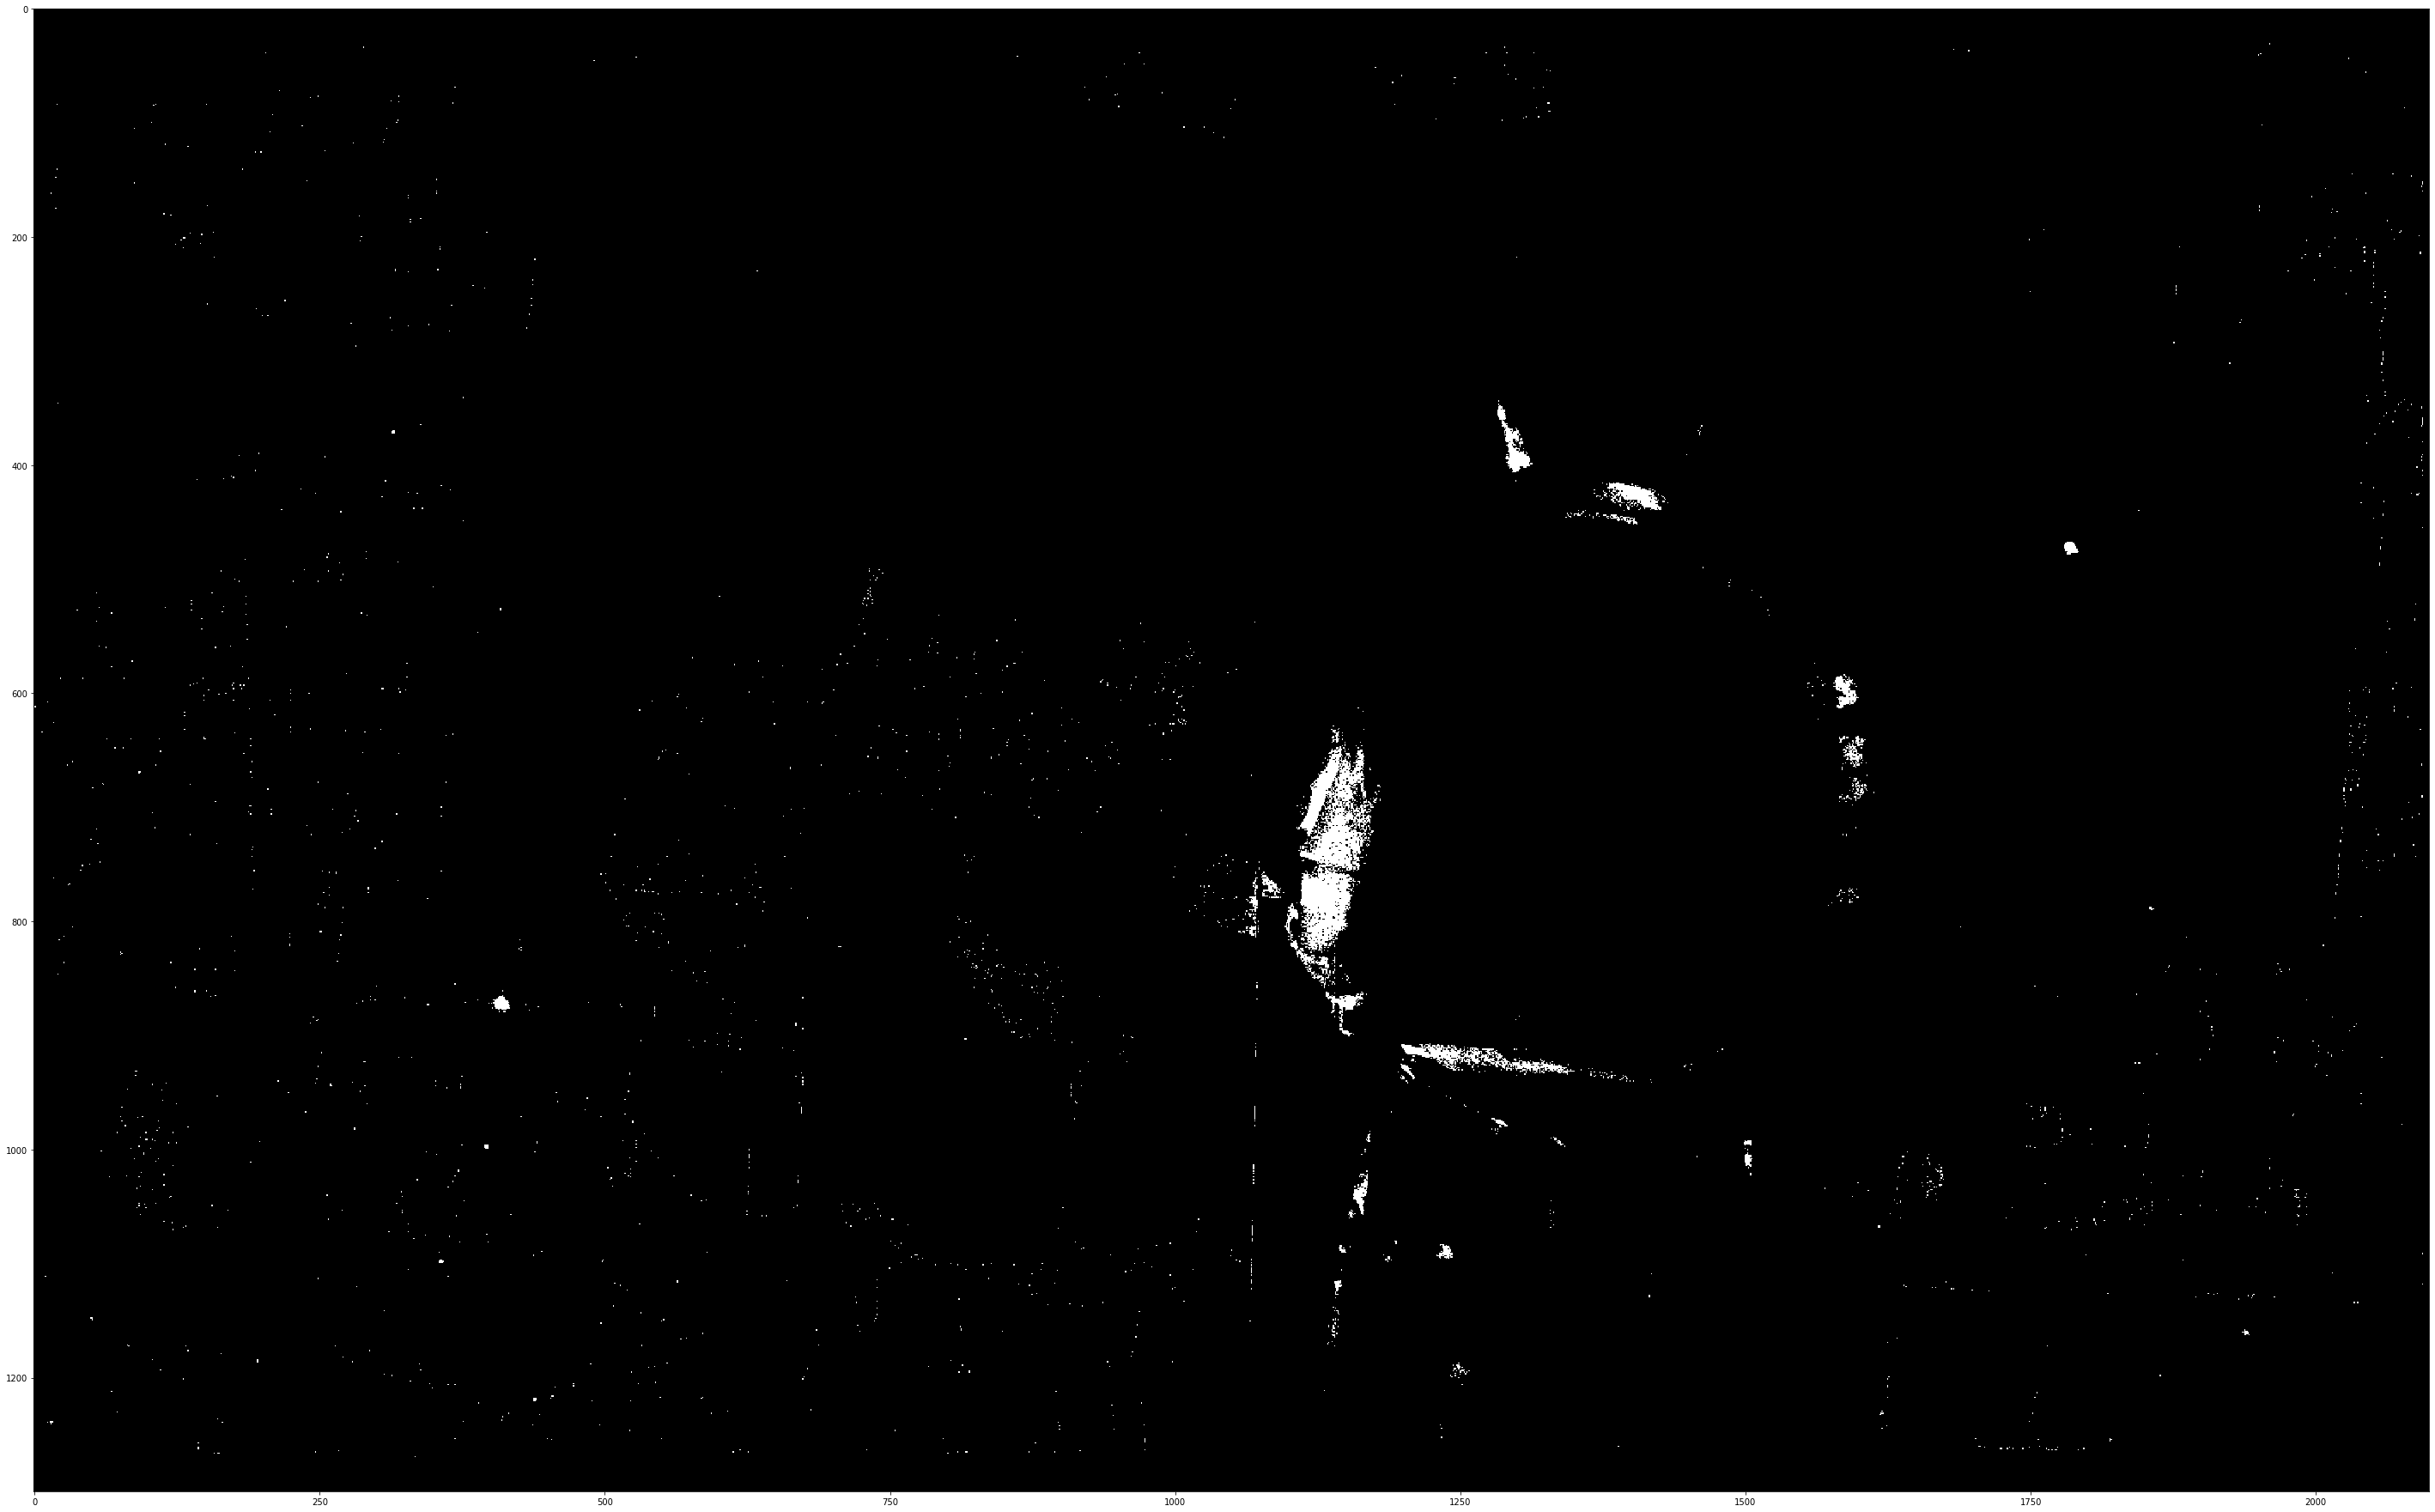

In [5]:
defect_map,mask_img = threshold_test(952229,0.2)
my_show_gray(mask_img)
cv2.imwrite('raw952229.png',mask_img*255)

## 14. False alarm elimination, 8 neighboring elimination

In [50]:
def cal_neighbor(current_frame):
    img_i,mask_img = threshold_test(current_frame+1,0.1)
    img_j,mask_img = threshold_test(current_frame,0.5)#current frame
    filters = np.array([[1, 1,1],[1,0,1], [1, 1, 1]])
    img_i_nb = signal.convolve2d(img_i, filters, fillvalue=0, mode = 'same')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img_i_nb_tensor = torch.from_numpy(img_i_nb).to(device) 
    img_j_tensor = torch.from_numpy(img_j).to(device) 
    tensor_zero = torch.zeros((1300,2100),dtype = torch.int32).to(device)
    new_map_tensor = torch.where(img_i_nb_tensor == 0, img_j_tensor, tensor_zero)
    new_map = new_map_tensor.cpu().numpy()
    return new_map, mask_img

## 15. Lucas Kanade Motion Tracker

In [53]:
def motion_track(current_frame):
    img_color,img_gray = extract_original(current_frame)

    prvs = img_gray.copy()
    hsv = np.zeros_like(img_color)
    hsv[...,1] = 255


    img_color,img_gray = extract_original(current_frame+1)
    current = img_gray.copy()

    flow = cv2.calcOpticalFlowFarneback(prvs,current, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

    rgb = cv2.cvtColor(hsv.astype(np.uint8),cv2.COLOR_HSV2BGR)
    
    kernel = np.ones((5,5),np.uint8)
    mag = cv2.dilate(mag.astype(np.uint8),kernel,iterations = 1)
    #cv2.imwrite('motion952229.png',rgb)
    return mag, rgb

In [54]:
motion_mag = motion_track(952229)

## 16. Neighbor elimination + Motion Elimination + Dilating the map

In [59]:
def eliminate_motion(current_frame):
    new_map, mask_img = cal_neighbor(current_frame)# After eliminate neighbors, before eliminate neighbors
    motion_mag,rgb = motion_track(current_frame)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    new_map_tensor = torch.from_numpy(new_map).to(device) 
    motion_mag_tensor = torch.from_numpy(motion_mag).to(device) 
    tensor_zero = torch.zeros((1300,2100),dtype = torch.int32).to(device)
    new_map_tensor = torch.where(motion_mag_tensor < 10, new_map_tensor, tensor_zero)
    motion_free_map = new_map_tensor.cpu().numpy()
    
    raw_motion_free = motion_free_map.copy()
    #cv2.imwrite(str(current_frame)+'motionfree.png',motion_free_map)
    #Step 1
    
    kernel = np.ones((5,5),np.uint8)
    motion_free_map = cv2.dilate(motion_free_map.astype(np.uint8),kernel,iterations = 1)
    motion_free_map = cv2.erode(motion_free_map.astype(np.uint8),kernel,iterations = 1)
    #Step 2
    kernel = np.ones((7,7),np.uint8)
    motion_free_map = cv2.dilate(motion_free_map.astype(np.uint8),kernel,iterations = 1)
    
    #cv2.imwrite(str(current_frame)+'dilation.png',motion_free_map*255)
    return mask_img, new_map, raw_motion_free, motion_free_map, rgb

## Integrated Restoration using Inpainting

In [60]:
def final_restore(current_frame):
    img_color,img_gray = extract_original(current_frame)
    img_color_t,img_gray_t = extract_final(current_frame)
    mask_img, new_map, raw_motion_free, motion_free_map, rgb = eliminate_motion(current_frame)
    mask = motion_free_map
    dst = cv2.inpaint(img_color.astype(np.uint8),mask.astype(np.uint8),3,cv2.INPAINT_TELEA)
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img_ori_tensor = torch.from_numpy(img_gray).to(device)
    img_fin_tensor = torch.from_numpy(img_gray_t).to(device)
    img_dif_tensor = torch.abs(img_fin_tensor - img_ori_tensor).to(device)
    tensor_one = torch.ones((1300,2100),dtype = torch.int32).to(device)
    tensor_zero = torch.zeros((1300,2100),dtype = torch.int32).to(device)
    img_dif_tensor = torch.where(img_dif_tensor > 50, img_dif_tensor, tensor_zero)
    img_dif_tensor = torch.where(img_dif_tensor < 50, img_dif_tensor, tensor_one)
    img_label = img_dif_tensor.cpu().numpy()
    print(img_label.shape)
    print(np.max(img_label))
    
    cv2.imwrite(str(current_frame)+'-1-Original.png',img_color)
    cv2.imwrite(str(current_frame)+'-2-GroundTruth.png',img_color_t)
    cv2.imwrite(str(current_frame)+'-3-InitialDetection.png',mask_img*255)
    cv2.imwrite(str(current_frame)+'-4-Eliminate_neighbor.png',new_map*255)
    cv2.imwrite(str(current_frame)+'-5-RawMotionFree.png',raw_motion_free*255)
    #cv2.imwrite(str(current_frame)+'-6-AfterDilation.png',motion_free_map*255)
    cv2.imwrite(str(current_frame)+'-7-Restored.png',dst)
    cv2.imwrite(str(current_frame)+'-8-Motion.png',rgb)
    cv2.imwrite(str(current_frame)+'-9-Label.png',img_label*255)

### Check Restoration: The intermediate files will also be saved to current folder

In [61]:
final_restore(952400)

(1300, 2100)
1
